Code for EE4540 Project assignment 

Standard imports

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
from matplotlib.animation import PillowWriter
from IPython.display import Image
from helper import min_radius_for_sensors
from randomizedgossip import compute_P_matrix


### • Average Consensus

Suppose the sensor network aims to compute the **average** value of the measurement data.

- Implement a **randomised gossip algorithm** as a baseline method.
- Then, implement the **average consensus problem** using the **PDMM (Primal-Dual Method of Multipliers)** algorithm.
- **Report**: Compare the performance in terms of convergence speed and number of transmissions between the two algorithms.


# Randomized Gossip Implementation

### Add randomized data to the coordinate points

Minimum required radius for connectivity with probability: 99.96000000000001 (n=50, area=100x100): 39.56 m


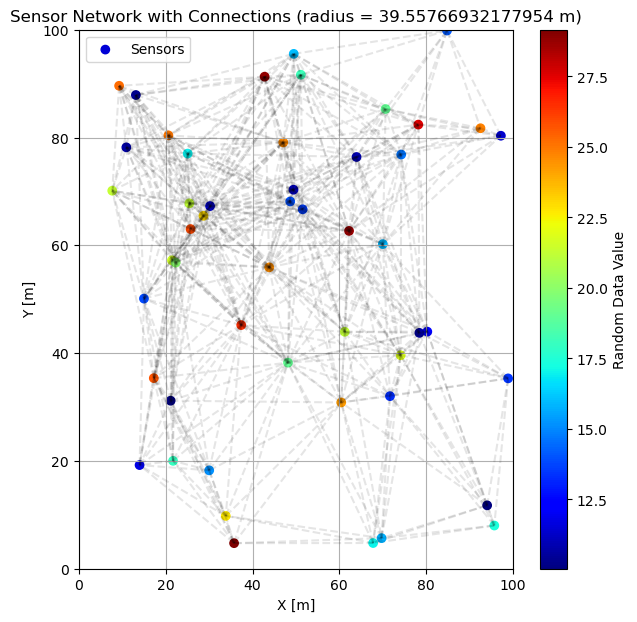

In [2]:
# Choose final parameters
NUM_SENSORS = 50
AREA_WIDTH = 100  # meters
DIMENSION = 2

# Ensure all sensors are connected with the desired radius
radius = min_radius_for_sensors(NUM_SENSORS, DIMENSION, AREA_WIDTH)

# Generate random sensor positions again for the augmented plot
coords = np.random.uniform(low = 0, high = AREA_WIDTH, size = (NUM_SENSORS, DIMENSION))

# coords has shape (N, 2)
random_column = np.random.uniform(low=10, high=30, size=(coords.shape[0], 1))  # shape (N, 1)

# concatenate along axis=1 (columns)
coords_augmented = np.hstack((coords, random_column))  # shape (N, DIMENSION + 1)

# Compute pairwise distances
dists = np.sqrt(np.sum((coords_augmented[:, None, 0:2] - coords_augmented[None, :, 0:2])**2, axis=-1))

adjacency = (dists <= radius) & (dists > 0)

# Create figure
plt.figure(figsize=(7, 7))

# Scatter plot with color based on random data
sc = plt.scatter(x = coords[:,0], y = coords[:,1], c=coords_augmented[:,2].flatten(), cmap='jet', label='Sensors')

# Draw dashed black lines for connected sensors
for i in range(NUM_SENSORS):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:  # Avoid duplicates
            plt.plot([coords[i, 0], coords[j, 0]],
                     [coords[i, 1], coords[j, 1]],
                     'k--', alpha=0.1)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Random Data Value')

# Final plot settings
plt.xlim(0, AREA_WIDTH)
plt.ylim(0, AREA_WIDTH)
plt.title(f'Sensor Network with Connections (radius = {radius} m)')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.legend()
plt.show()



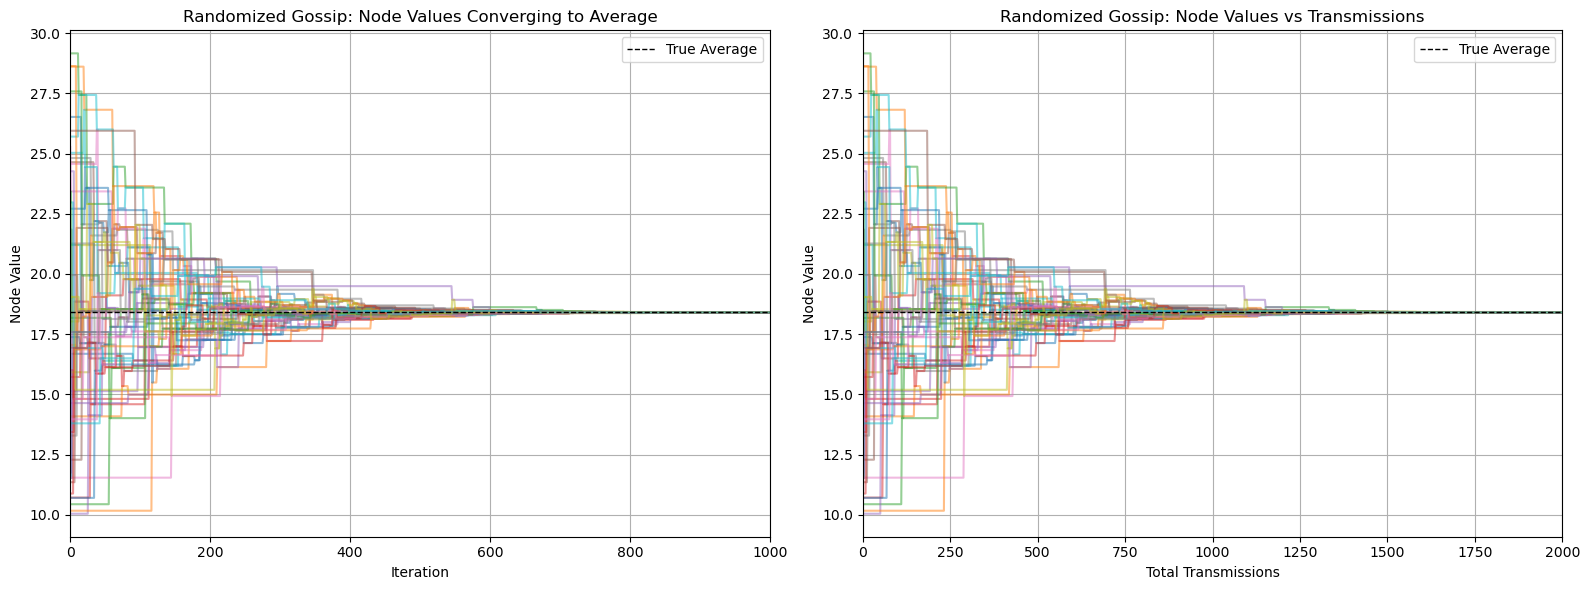

In [ ]:
#from randomizedgossip import randomized_gossip_average

def get_W_bar(P, adjacency):
    N = adjacency.shape[0]
    W_bar = np.zeros_like(adjacency, dtype='float64')

    for i in range(N):
        for j in range(N):
            if adjacency[i, j]:
                e_i = np.zeros((N, 1)); e_i[i] = 1
                e_j = np.zeros((N, 1)); e_j[j] = 1
                W_ij = np.eye(N) - 0.5 * (e_i - e_j) @ (e_i - e_j).T
                W_bar += P[i, j] * W_ij
    
    return W_bar / N




def calculate_W_bar(P, adjacency):
    """
    Calculate the W_bar matrix based on the P matrix and adjacency matrix.
    
    Parameters:
        P: (N, N) matrix, probability matrix for gossip communication
        adjacency: (N, N) boolean array, adjacency matrix of the network
    
    Returns:
        W_bar: (N, N) matrix, average gossip weight matrix
    """
    N = adjacency.shape[0]
    W_bar = np.zeros((N, N), dtype='float64')

    for i in range(N):
        for j in range(N):
            if adjacency[i, j]:
                e_i = np.zeros((N, 1)); e_i[i] = 1
                e_j = np.zeros((N, 1)); e_j[j] = 1
                W_ij = np.eye(N) - 0.5 * (e_i - e_j) @ (e_i - e_j).T
                W_bar += P[i, j] * W_ij
    
    return W_bar / N

def randomized_gossip_average(adjacency, values, P, num_iters=1000, verbose=False):
    """
    Runs the randomized gossip algorithm to compute the average of the initial values.
    
    Parameters:
        adjacency: (N, N) boolean array, adjacency matrix of the network
        values: (N,) array, initial values at each node
        num_iters: int, number of gossip iterations
        verbose: bool, if True, prints progress
    
    Returns:
        history: list of arrays, value at each node after each iteration
    """
    real_avg = np.mean(values)  # Calculate the true average of the initial values
    N = len(values)
    x = values.copy()
    history = [x.copy()]
    transmissions = [0]  # List to keep track of transmissions per iteration
    tx = 0  # Initialize transmission count
    for k in range(num_iters):
        # Randomly select an edge (i, j) from the adjacency matrix
        i = np.random.randint(N)
        neighbors = np.where(adjacency[i])[0]
        if len(neighbors) == 0:
            continue  # skip isolated node
        j = np.random.choice(len(P[i]), p=P[i]/np.sum(P[i]))  # Choose neighbor j based on probabilities in P
        # Both nodes update to their average
        avg = 0.5 * (x[i] + x[j])
        x[i] = avg
        x[j] = avg
        tx += 2  # Count the number of transmissions
        history.append(x.copy())
        transmissions.append(tx)
        err = np.linalg.norm(x - real_avg)/np.linalg.norm(real_avg)  # Calculate the normalized error from the real average
        if err < 1e-12:
            if verbose:
                print(f"Converged at iteration {k} with max error {err:.14f}")
            break
        if verbose and k % 100 == 0:
            print(f"Iter {k}: max error = {err:.10f}")
    return k, history, real_avg, transmissions


# Compute the regular P matrix based on the adjacency matrix
P = adjacency.astype(float) / adjacency.sum(axis=1, keepdims=True)  # Normalize rows to sum to 1

k, gossip_history, real_avg, transmissions = randomized_gossip_average(adjacency, coords_augmented[:, 2], P = P, num_iters=10000)

# Run the randomized gossip algorithm with the optimized weights by inputting matrix P

opt_P = compute_P_matrix(adjacency)
# Run the randomized gossip algorithm with the optimized P matrix
k, optimal_gossip_history, real_avg, optimal_transmissions = randomized_gossip_average(adjacency, coords_augmented[:, 2], P = opt_P, num_iters=10000)

# plot the above plots in a single figure with two subplots next to each other
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].set_title('Randomized Gossip: Node Values Converging to Average')
for i in range(NUM_SENSORS):
    axs[0].plot([x[i] for x in optimal_gossip_history], alpha=0.5)
axs[0].axhline(real_avg, color='black', linestyle='--', label='True Average', linewidth=1)
axs[0].legend()
axs[0].set_xlabel('Iteration')
axs[0].set_xlim(0, 1000)
axs[0].set_ylabel('Node Value')
axs[0].grid(True)
axs[1].set_title('Randomized Gossip: Node Values vs Transmissions')
for i in range(NUM_SENSORS):
    axs[1].plot(optimal_transmissions, [x[i] for x in optimal_gossip_history], alpha=0.5)
axs[1].axhline(real_avg, color='black', linestyle='--', label='True Average', linewidth=1)
axs[1].legend()
axs[1].set_xlabel('Total Transmissions')
axs[1].set_xlim(0, 2000)
axs[1].set_ylabel('Node Value')
axs[1].grid(True)
plt.tight_layout()
plt.show()

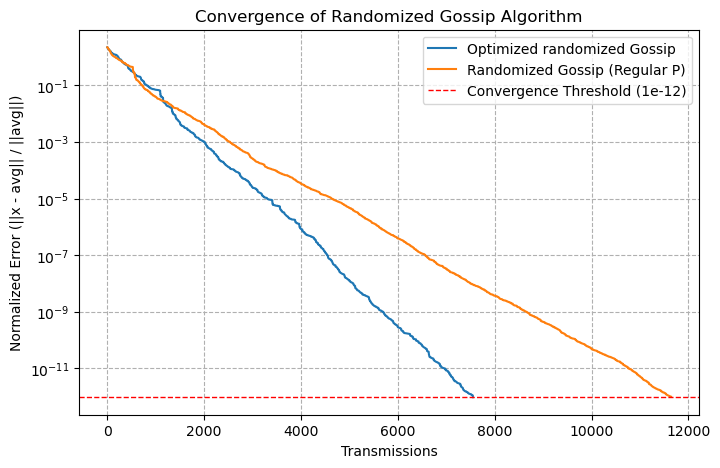

In [44]:
#Calculate the normalized error at each iteration
optimal_errors = [np.linalg.norm(x - real_avg) / np.linalg.norm(real_avg) for x in optimal_gossip_history]

errors = [np.linalg.norm(x - real_avg) / np.linalg.norm(real_avg) for x in gossip_history]

# Plot on a logarithmic y-axis
plt.figure(figsize=(8, 5))
plt.semilogy(optimal_transmissions, optimal_errors, label='Optimized randomized Gossip')
plt.semilogy(transmissions, errors, label='Randomized Gossip (Regular P)')
plt.axhline(1e-12, color='red', linestyle='--', label='Convergence Threshold (1e-12)', linewidth=1)
plt.xlabel('Transmissions')
plt.ylabel('Normalized Error (||x - avg|| / ||avg||)')
plt.title('Convergence of Randomized Gossip Algorithm')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

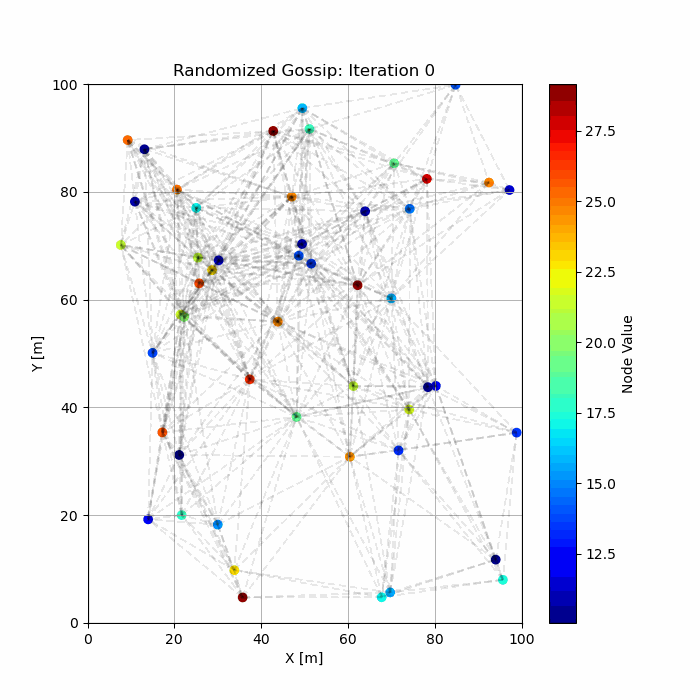

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

# Custom frame selection: dense at start, sparser after convergence to reduce video size
frames = []
frames += list(range(0, 50, 1))        # Every 1 frames from 0 to 50
frames += list(range(50, 350, 3))      # Every 10th frame from 10 to 499
frames += list(range(350, 1000, 10))  # Every 300th frame after 500


# Prepare the figure
fig, ax = plt.subplots(figsize=(7, 7))
scat = ax.scatter(coords[:, 0], coords[:, 1], c=optimal_gossip_history[0], cmap='jet', vmin=np.min(optimal_gossip_history[0]), vmax=np.max(optimal_gossip_history[0]))
ax.set_xlim(0, AREA_WIDTH)
ax.set_ylim(0, AREA_WIDTH)
ax.set_title('Randomized Gossip: Node Values Animation')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid(True)

# Draw the static network connections (lines)
for i in range(NUM_SENSORS):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:
            ax.plot([coords[i, 0], coords[j, 0]],
                    [coords[i, 1], coords[j, 1]],
                    'k--', alpha=0.1)

# Add colorbar
cbar = plt.colorbar(scat, ax=ax)
cbar.set_label('Node Value')

# Animation update function
def update(frame):
    values = optimal_gossip_history[frame]
    scat.set_array(values)
    ax.set_title(f'Randomized Gossip: Iteration {frame}')
    return scat

mpl.rcParams['animation.embed_limit'] = 100.0  # default is 20.0 MB

# Create the animation (adjust interval and frames as needed)
ani = animation.FuncAnimation(
    fig, update, frames=frames, interval=100, blit=False, repeat=True
)

plt.close(fig)  # Prevents duplicate static plot

# HTML(ani.to_jshtml())  # Display the animation

# Store the animation with pillow writer
writer = PillowWriter(fps=10)
ani.save('animations/randomized_gossip.gif', writer=writer)  # Save the PDMM animation with broadcasting

# Show the PDMM animation with broadcasting from the written file
Image(filename='animations/randomized_gossip.gif')

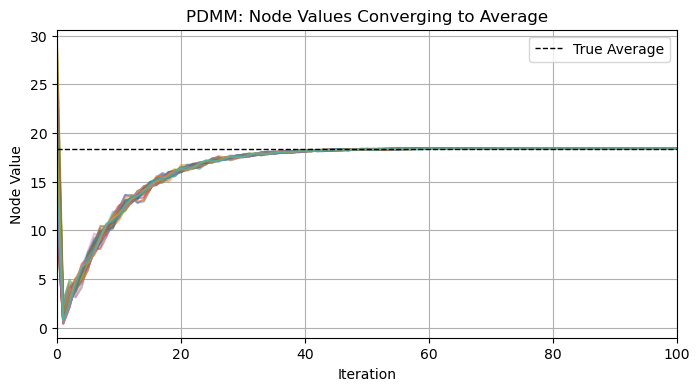

In [45]:
from pdmm_average_consensus import pdmm_average_consensus

k, real_avg, pdmm_history, tx = pdmm_average_consensus(adjacency, coords_augmented[:, 2], num_iters=1000, c = 1, verbose=False, Broadcast=True)

# Plot convergence
plt.figure(figsize=(8, 4))
for i in range(NUM_SENSORS):
    plt.plot([x[i] for x in pdmm_history], alpha=0.5)
plt.axhline(real_avg, color='black', linestyle='--', label='True Average', linewidth=1)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Node Value')
plt.title('PDMM: Node Values Converging to Average')
plt.grid(True)
plt.xlim(0, 100)
plt.show()


# C value optimization

In [ ]:
c = np.linspace(0.01, 1, 100)
# Calculate amount of iterations for each c
iterations = []
transmissions = []
for c_value in tqdm(c):
    k, _, _, tx = pdmm_average_consensus(adjacency, coords_augmented[:, 2], num_iters=1000, c=c_value, verbose=False)
    iterations.append(k)
    transmissions.append(tx)



100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Minimum transmissions: 64540 for c = 0.09999999999999999


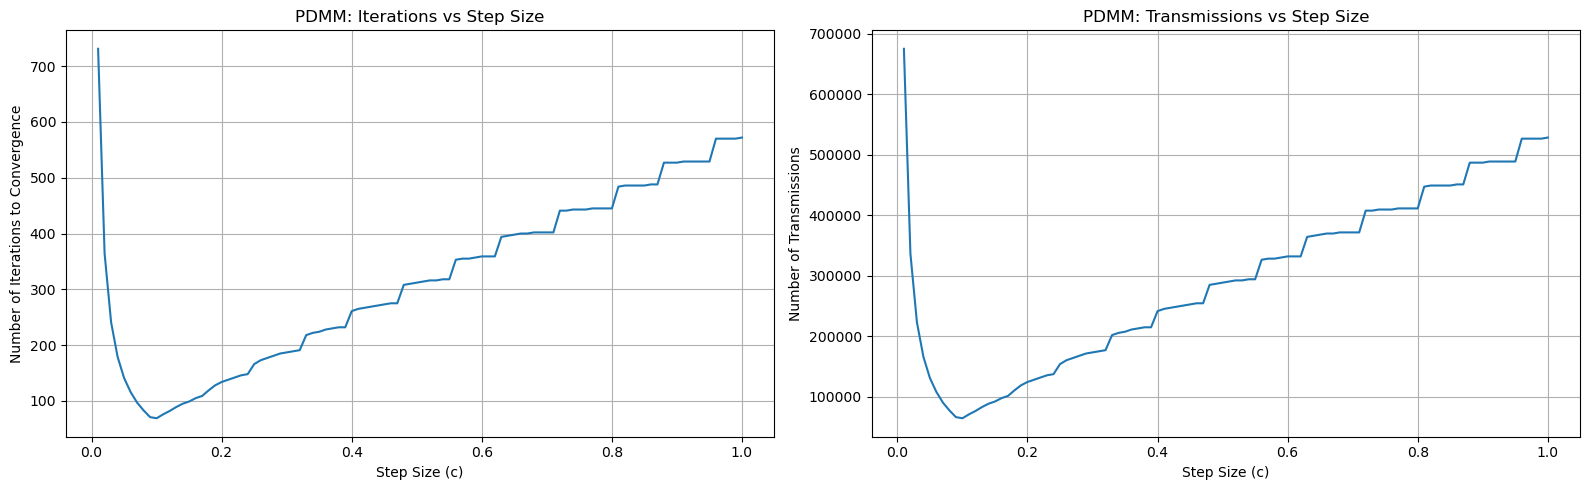

In [25]:
# print the c value that gives the least number of transmissions
min_transmissions = min(transmissions)
print(f'Minimum transmissions: {min_transmissions} for c = {c[np.argmin(transmissions)]}')

#Now put the plots together in a subfigure
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].plot(c, iterations)
axs[0].set_xlabel('Step Size (c)')
axs[0].set_ylabel('Number of Iterations to Convergence')
axs[0].set_title('PDMM: Iterations vs Step Size')
axs[0].grid(True)
axs[1].plot(c, transmissions)
axs[1].set_xlabel('Step Size (c)')
axs[1].set_ylabel('Number of Transmissions')
axs[1].set_title('PDMM: Transmissions vs Step Size')
axs[1].grid(True)
plt.tight_layout()
plt.show()

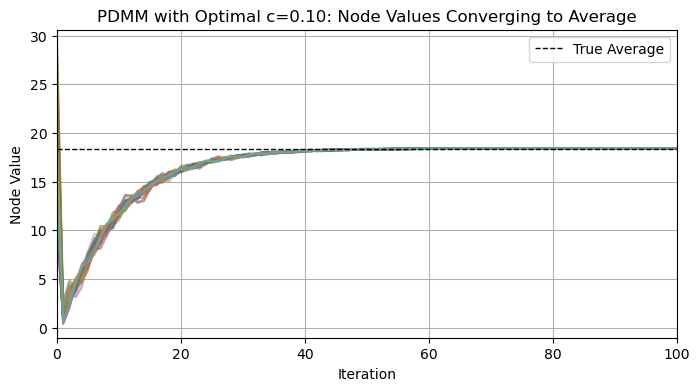

In [ ]:
#Use the optimal c value to run PDMM again with broadcasting
optimal_c = c[np.argmin(transmissions)]
k, real_avg, pdmm_broadcast_history, tx = pdmm_average_consensus(adjacency, coords_augmented[:, 2], num_iters=1000, c=optimal_c, verbose=False, Broadcast=True)
# Plot convergence with optimal c
plt.figure(figsize=(8, 4))
for i in range(NUM_SENSORS):
    plt.plot([x[i] for x in pdmm_history], alpha=0.5)
plt.axhline(real_avg, color='black', linestyle='--', label='True Average', linewidth=1)
plt.legend()   
plt.xlabel('Iteration')
plt.ylabel('Node Value')
plt.title(f'PDMM with Optimal c={optimal_c:.2f}: Node Values Converging to Average')
plt.grid(True)
plt.xlim(0, 100)
plt.show()


In [ ]:
# Reset custom frames for PDMM animation with no skipping
frames = list(range(len(pdmm_broadcast_history)))

# Create a new figure for the final PDMM animation
fig, ax = plt.subplots(figsize=(7, 7))
scat = ax.scatter(coords[:, 0], coords[:, 1], c=initial_values, cmap='jet', vmin=np.min(initial_values), vmax=np.max(initial_values))
scat = ax.scatter(coords[:, 0], coords[:, 1], c=pdmm_broadcast_history[0], cmap='jet', vmin=np.min(pdmm_broadcast_history[0]), vmax=np.max(pdmm_broadcast_history[0]))
ax.set_xlim(0, AREA_WIDTH)
ax.set_ylim(0, AREA_WIDTH)
ax.set_title('PDMM with broadcasting: Node Values Animation')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid(True)
# Draw the static network connections (lines)
for i in range(NUM_SENSORS):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:
            ax.plot([coords[i, 0], coords[j, 0]],
                    [coords[i, 1], coords[j, 1]],
                    'k--', alpha=0.1)
# Add colorbar
cbar = plt.colorbar(scat, ax=ax)
cbar.set_label('Node Value')
# Animation update function for PDMM
def pdmm_broadcast_update(frame):
    values = pdmm_broadcast_history[frame]
    scat.set_array(values)
    ax.set_title(f'PDMM with broadcasting: Iteration {frame}')
    return scat
# Create the PDMM animation
ani_pdmm = animation.FuncAnimation(
    fig, pdmm_broadcast_update, frames=frames, interval=500, blit=False, repeat=True
)
plt.close(fig)  # Prevents duplicate static plot

# Store the animation with pillow writer
writer = PillowWriter(fps=2)
ani_pdmm.save('animations/pdmm_broadcast_animation.gif', writer=writer)  # Save the PDMM animation with broadcasting

# Show the PDMM animation with broadcasting from the written file
Image(filename='animations/pdmm_broadcast_animation.gif')

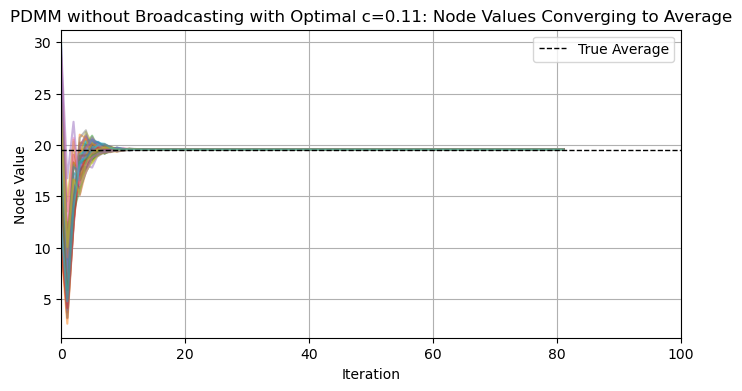

In [ ]:
# Use the optimal c value to run PDMM without broadcasting
k, real_avg, pdmm_no_broadcast_history, tx = pdmm_average_consensus(adjacency, coords_augmented[:, 2], num_iters=1000, c=optimal_c, verbose=False, Broadcast=False)
# Plot convergence without broadcasting
plt.figure(figsize=(8, 4))
for i in range(NUM_SENSORS):
    plt.plot([x[i] for x in pdmm_no_broadcast_history], alpha=0.5)
plt.axhline(real_avg, color='black', linestyle='--', label='True Average', linewidth=1)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Node Value')
plt.title(f'PDMM without Broadcasting with Optimal c={optimal_c:.2f}: Node Values Converging to Average')
plt.grid(True)
plt.xlim(0, 100)
plt.show()

In [ ]:
# Reset custom frames for PDMM animation without broadcasting
frames = list(range(len(pdmm_no_broadcast_history)))

# Create a new figure for the PDMM animation without broadcasting
fig, ax = plt.subplots(figsize=(7, 7))
scat = ax.scatter(coords[:, 0], coords[:, 1], c=pdmm_no_broadcast_history[0], cmap='jet', vmin=np.min(pdmm_no_broadcast_history[0]), vmax=np.max(pdmm_no_broadcast_history[0]))
ax.set_xlim(0, AREA_WIDTH)
ax.set_ylim(0, AREA_WIDTH)
ax.set_title('PDMM without Broadcasting: Node Values Animation')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid(True)
# Draw the static network connections (lines)
for i in range(NUM_SENSORS):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:
            ax.plot([coords[i, 0], coords[j, 0]],
                    [coords[i, 1], coords[j, 1]],
                    'k--', alpha=0.1)
# Add colorbar
cbar = plt.colorbar(scat, ax=ax)
cbar.set_label('Node Value')
# Animation update function for PDMM without broadcasting
def pdmm_no_broadcast_update(frame):
    values = pdmm_no_broadcast_history[frame]
    scat.set_array(values)
    ax.set_title(f'PDMM without Broadcasting: Iteration {frame}')
    return scat
# Create the PDMM animation without broadcasting
ani_pdmm_no_broadcast = animation.FuncAnimation(
    fig, pdmm_no_broadcast_update, frames=frames, interval=500, blit=False, repeat=True
)
plt.close(fig)  # Prevents duplicate static plot

# Store the animation with pillow writer
writer = PillowWriter(fps=10)
ani_pdmm_no_broadcast.save('animations/pdmm_no_broadcast_animation.gif', writer=writer)  # Save the PDMM animation without broadcasting

# Show the PDMM animation without broadcasting from the written file
Image(filename='animations/pdmm_no_broadcast_animation.gif')

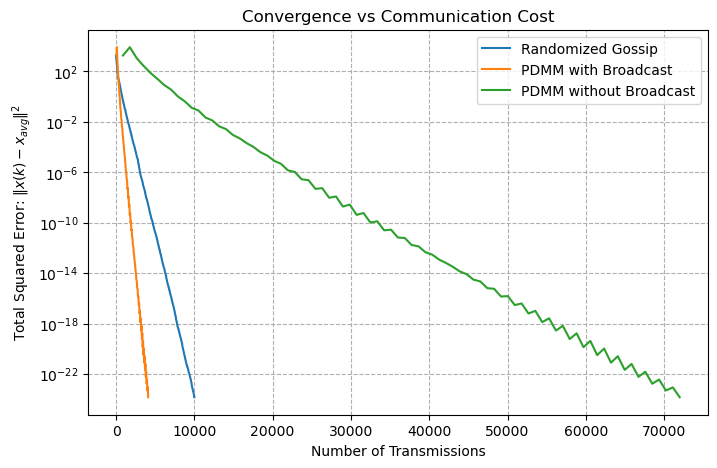

In [14]:
# # Calculate the squared error at each iteration
pdmm_broadcast_errors = [np.sum((x - real_avg)**2) for x in pdmm_broadcast_history]
pdmm_no_broadcast_errors = [np.sum((x - real_avg)**2) for x in pdmm_no_broadcast_history]


# Calculate transmissions for gossip (1 per iteration)
gossip_transmissions = list(range(len(errors)))  # Each iteration is one transmission

# Create x-axis points for PDMM based on cumulative transmissions
pdmm_broadcast_tx = []
pdmm_no_broadcast_tx = []
tx_count = 0
for i in range(len(pdmm_broadcast_history)):
    tx_count += NUM_SENSORS  # In broadcast mode, each iteration sends to all neighbors
    pdmm_broadcast_tx.append(tx_count)

tx_count = 0
for i in range(len(pdmm_no_broadcast_history)):
    tx_count += sum(np.sum(adjacency, axis=1))  # Count all edge transmissions
    pdmm_no_broadcast_tx.append(tx_count)

# Plot the error vs transmissions on a logarithmic y-axis
plt.figure(figsize=(8, 5))
plt.semilogy(gossip_transmissions, errors, label='Randomized Gossip')
plt.semilogy(pdmm_broadcast_tx, pdmm_broadcast_errors, label='PDMM with Broadcast')
plt.semilogy(pdmm_no_broadcast_tx, pdmm_no_broadcast_errors, label='PDMM without Broadcast')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Number of Transmissions')
plt.ylabel(r'Total Squared Error: $\|x(k) - x_{avg}\|^2$')
plt.title('Convergence vs Communication Cost')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()